In [2]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

from aind_vr_foraging_analysis.utils.parsing import parse, AddExtraColumns, data_access
import aind_vr_foraging_analysis.utils.plotting as plotting

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents'

from scipy.optimize import curve_fit


# **One session exploration**

In [84]:
date_string = "2024-10-11"
mouse = '745302'

In [ ]:
session_paths = data_access.find_sessions_relative_to_date(
    mouse=mouse,
    date_string=date_string,
    when='on'
)

for session_path in session_paths:
    try:
        all_epochs, stream_data, data = data_access.load_session(
            session_path
        )
        reward_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']
    except Exception as e:
        print(f"Error loading {session_path.name}: {e}")

In [ ]:
change = data['software_events'].streams['Block'].data['data'].index[1]
reward_sites['block'] = np.where(reward_sites.index <= change, 0, 1)
reward_sites['patch_label'] = np.where(reward_sites['block'] == 1, reward_sites['patch_label'] +'_after', reward_sites['patch_label'])
reward_sites['odor_label'] = np.where(reward_sites['block'] == 1, reward_sites['odor_label'] +'_after', reward_sites['odor_label'])

In [30]:
# # Recover color palette
# color_dict_label = {}
# dict_odor = {}
# list_patches = parse.TaskSchemaProperties(data).patches
# for i, patches in enumerate(list_patches):
#     color_dict_label[patches['label']] = odor_list_color[i]
#     dict_odor[i] = patches['label']

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'patch_single': color1,
    'patch_delayed': color2,
    'patch_no_reward': color3,
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}

In [62]:
# Summary of different relevants aspects -------------------------------------------------
unrewarded_stops = reward_sites.loc[reward_sites.is_reward==0]['is_choice'].count()
rewarded_stops = reward_sites.loc[reward_sites.is_reward==1]['is_choice'].count()
water_collected = reward_sites.loc[(reward_sites['is_reward']==1)]['reward_amount'].sum()
total_stops = reward_sites.loc[(reward_sites['is_choice']==True)]['reward_available'].count()

# Rewarded stops / total available rewarded stops
optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['is_reward'].count()

# Rewarded stops / Stops
efficiency = rewarded_stops / reward_sites.is_reward.sum()

print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

if 'startPosition' in all_epochs.columns:
    stop_duration = np.round(all_epochs.startPosition.max()/100,2)
else:
    stop_duration = np.round(all_epochs.start_position.max()/100,2)
print('Total travelled m: ', np.round(all_epochs.start_position.max()/100,2))

for odor_label in reward_sites.odor_label.unique():
    values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['is_reward']==1)]['reward_amount'].sum()
    print(f'{odor_label} {values} ul')

Total sites:  280  |  Total rewarded stops:  66 ( 54.1 %) |  Total unrewarded stops:  214 ( 175.41 %) |  Water consumed:  330.0 ul
Total travelled m:  784.84
Methyl Butyrate 0.0 ul
Fenchone 210.0 ul
Alpha-pinene 120.0 ul


## Dynamic plot on time

In [32]:
def update_plot(x_start):
    zero_index = all_epochs.index[0]

    fig, axs = plt.subplots(1,1, figsize=(20,4))
    
    _legend = {}
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    # _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index,
    #         stream_data.choice_feedback.index * 0 + y_idx,
    #         marker="s", s=100, lw=lw, c='darkblue',
    #         label="Choice Tone")
    software_tone = data['software_events'].streams['ChoiceFeedback'].data.index
    _legend["SoftTone"] = axs.scatter(software_tone - zero_index,
            software_tone*0 + y_idx,
            marker=".", s=s, lw=lw, c='green',
            label="SoftwareTone")
    
    y_idx += 1
    # _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
    #         stream_data.lick_onset.index * 0 + y_idx,
    #         marker="|", s=s, lw=lw, c='k',
    #         label="Lick")
    
    _legend["Reward"] = axs.scatter(all_epochs['reward_onset_time'] - zero_index,
            all_epochs['reward_onset_time']*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")

    
    software_water = data['software_events'].streams['GiveReward'].data.index
    _legend["SoftReward"] = axs.scatter(software_water - zero_index,
            software_water*0 + y_idx,
            marker="x", s=s, lw=lw, c='red',
            label="SoftwareReward")
    
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_triggers.odor_onset - zero_index,
    #     odor_triggers.odor_onset*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_triggers.odor_offset - zero_index,
    #     odor_triggers.odor_offset*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-10, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    ax2.hlines(0, 0, all_epochs.index[-1] - zero_index, lw=1)
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 100])
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 100

def on_right_button_clicked(button):
    x_start_widget.value += 100

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

## Dynamic plot on position

In [68]:
def add_position(df: pd.DataFrame, position:  pd.DataFrame):
    position.rename_axis('Time', axis='index', inplace=True)
    df.rename_axis('Time', axis='index', inplace=True)

    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

In [70]:
def update_plot(x_start):
    zero_index = all_epochs.index[0]
    position = stream_data.position_data
    
    fig, ax = plt.subplots(figsize=(20,4))
    _legend = {}

    _sites = add_position(all_epochs, position=position)

    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (_sites["Position"].iloc[idx], -2), _sites["Position"].iloc[idx+1] - _sites["Position"].iloc[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = 0.5 )
        _legend[site_label] = p
        ax.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = 2.5
    _legend["ChoiceFeedback"] = ax.scatter(add_position(stream_data.choice_feedback, position=position)["Position"].values,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='k',
            label="ChoiceFeedback")
    
    y_idx = 1
    _legend["Lick"] = ax.scatter(add_position(stream_data.lick_onset, position=position)["Position"].values,
               stream_data.lick_onset.index * 0 + y_idx,
               marker="|", s=s, lw=lw, c='k',
               label="Lick")
    
    # odor_triggers = stream_data.odor_triggers
    # odor_triggers.index = odor_triggers.odor_onset
    # odor_triggers.rename_axis('Time', axis='index', inplace=True)
    # _legend["Odor_on"] = ax.scatter(add_position(odor_triggers.odor_onset, position=position)["Position"].values,
    #     odor_triggers.odor_onset*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")

    # odor_triggers.index = odor_triggers.odor_offset
    # odor_triggers.rename_axis('Time', axis='index', inplace=True)
    # _legend["Odor_off"] = ax.scatter(add_position(odor_triggers.odor_offset, position=position)["Position"].values,
    #     odor_triggers.odor_offset*0 + 1.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="OFF")
    
    y_idx = 3.5
    _legend["ValveOpen"] = ax.scatter(add_position(stream_data.give_reward, position=position)["Position"].values,
               stream_data.give_reward.index*0 + y_idx,
               marker=".", s=s, lw=lw, c='mediumblue',
               label="ValveOpen")
    
    ax.set_yticklabels([])
    ax.set_xlabel("VrSpace(cm)")
    ax.grid(False)
    ax.set_ylim(bottom=-1, top = 4)
    ax.set_yticks([0,3])
    ax.yaxis.tick_right()
    ax.set_xlim([x_start, x_start + 500])
    # ax.set_xlim(_sites.loc[(_sites.index - zero_index > win[0]) & (_sites.index - zero_index < win[1]), :]["Position"].values[[0, -1]])
    ax.grid(False)

    ax2 = ax.twinx()
    _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=position)["Position"].values, stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    # v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    # _legend["Velocity_Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 50))
    ax2.set_ylabel("Velocity (cm/s)")
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 250

def on_right_button_clicked(button):
    x_start_widget.value += 250

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

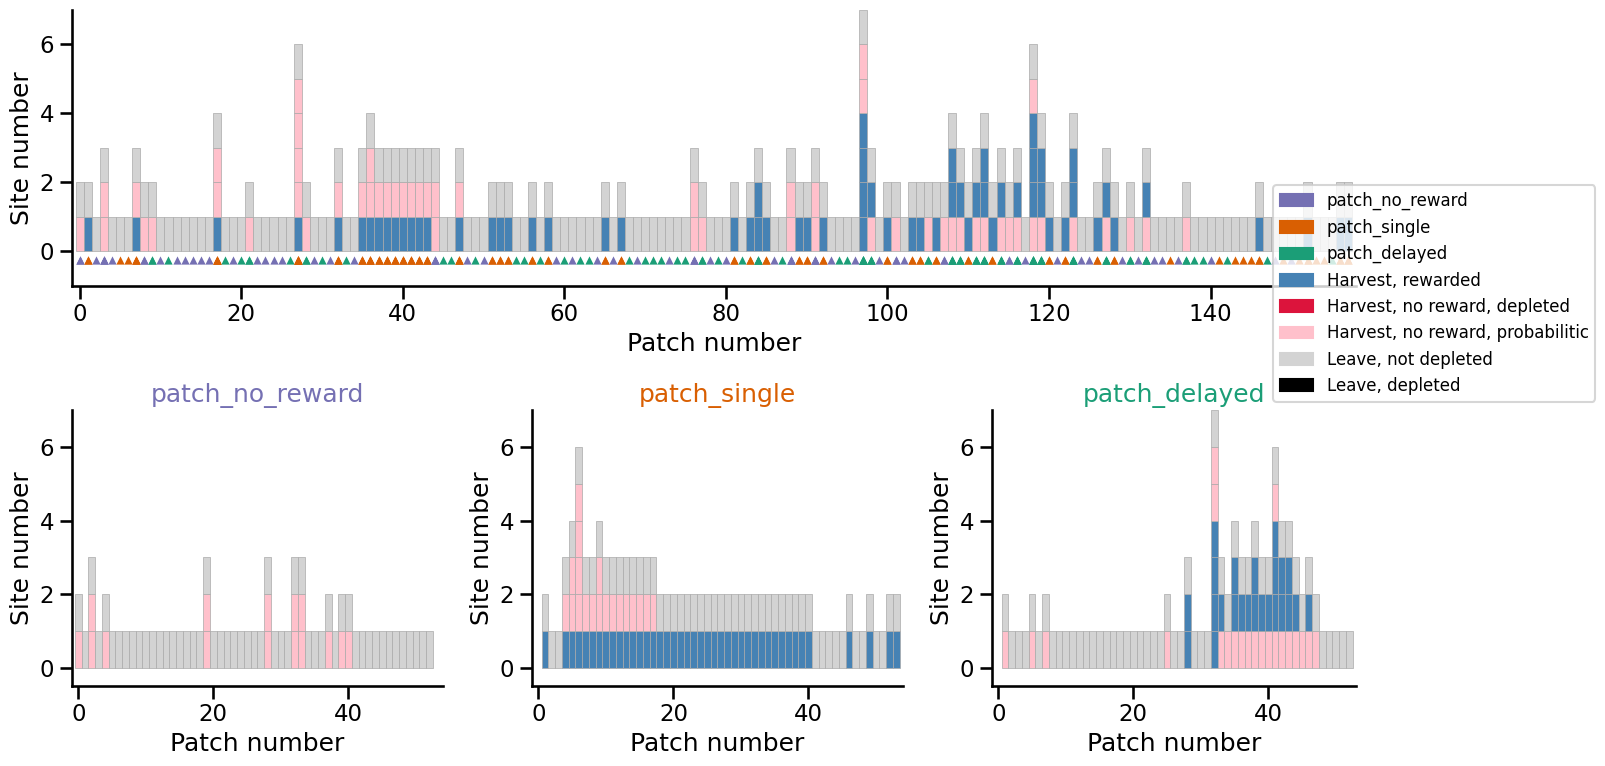

In [33]:
all_epochs['odor_label'] = all_epochs['patch_label']
plotting.segmented_raster_vertical(all_epochs.loc[all_epochs['label'] == 'OdorSite'], 
                                data['config'], 
                                color_dict_label=color_dict_label)

In [75]:
def plot_patches(ax, navigation_mode, x_start, zero_index):
    """Plot the context patches based on the navigation mode."""
    _sites = add_position(all_epochs, position=data['operation_control'].streams.CurrentPosition.data)
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        if navigation_mode == "space":
            position = _sites["Position"].iloc[idx]
            width = _sites["Position"].iloc[idx + 1] - position
            p = Rectangle((position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)
        else:
            time_position = all_epochs.index[idx] - zero_index
            width = all_epochs.index[idx + 1] - all_epochs.index[idx]
            p = Rectangle((time_position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)

        ax.add_patch(p)

def plot_behavioral_events(ax, navigation_mode, x_start, zero_index):
    """Plot behavioral events like ChoiceFeedback, Lick, ValveOpen."""
    s, lw = 400, 2
    y_idx = 2.5
    # ChoiceFeedback
    ax.scatter(
        add_position(stream_data.choice_feedback, position=data['operation_control'].streams.CurrentPosition.data)["Position"].values,
        stream_data.choice_feedback.index * 0 + y_idx,
        marker="s", s=100, lw=lw, c='k', label="ChoiceFeedback")

    y_idx = 1
    # Lick
    ax.scatter(
        add_position(stream_data.lick_onset, position=data['operation_control'].streams.CurrentPosition.data)["Position"].values,
        stream_data.lick_onset.index * 0 + y_idx,
        marker="|", s=s, lw=lw, c='k', label="Lick")

    y_idx = 3.5
    # ValveOpen
    ax.scatter(
        add_position(stream_data.give_reward, position=data['operation_control'].streams.CurrentPosition.data)["Position"].values,
        stream_data.give_reward.index * 0 + y_idx,
        marker=".", s=s, lw=lw, c='mediumblue', label="ValveOpen")

In [ ]:
# Define a dictionary to map navigation modes to corresponding limits and increments
nav_config = {
    "patch": {"increment": 1},  # For patches, we move one patch at a time
    "time": {"increment": 100},
    "space": {"increment": 250}
}

def update_plot(x_start, navigation_mode="patch"):
    """
    Update the plot based on the selected navigation mode (space, time, or patch).
    
    Parameters:
    ----------
    x_start : float
        The starting value for the x-axis (time or position or patch number).
    navigation_mode : str
        Mode of navigation: 'patch', 'time', or 'space'.
    """
    zero_index = all_epochs.index[0]
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 4))
    
    # Get the configuration for the selected navigation mode
    nav_mode = nav_config.get(navigation_mode, nav_config["patch"])  # Default to 'patch' if mode is invalid
    
    if navigation_mode == "patch":
        # Get the start and end times of patches
        patch_start_times = all_epochs.loc[all_epochs['label'] == 'OdorSite'].index
        patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
        patches = list(zip(patch_start_times, patch_end_times))

        # Determine the current patch
        current_patch = int(x_start)  # Use the integer part of x_start as the patch index
        start, end = patches[current_patch]

        # Set the x-limits for the current patch
        ax.set_xlim(start - zero_index, end - zero_index)
        
    else:
        # Use the configured x-limits for time or space navigation
        ax.set_xlim(x_start, x_start + nav_mode.get("increment"))

    # Plot context patches (the "OdorSite", "InterPatch" regions)
    plot_patches(ax, navigation_mode, x_start, zero_index)
    
    # Plot behavioral events (e.g., ChoiceFeedback, Lick, ValveOpen)
    plot_behavioral_events(ax, navigation_mode, x_start, zero_index)
    
    # Plot the velocity curve
    ax2 = ax.twinx()
    _legend = {}
    _legend["Velocity"] = ax2.plot(
        stream_data.encoder_data.index - zero_index,
        stream_data.encoder_data.filtered_velocity,
        c="k", label="Velocity", alpha=0.8
    )[0]
    
    # Customize axis labels, limits, and grid
    ax.set_yticklabels([])
    ax.set_xlabel("Time (s)" if navigation_mode != "space" else "VR Space (cm)")
    ax.set_ylim(bottom=-1, top=4)
    ax.set_yticks([0, 3])
    ax.yaxis.tick_right()
    
    ax.grid(False)
    
    ax2.set_ylim((-5, 50))
    ax2.set_ylabel("Velocity (cm/s)")
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Define callback functions for the arrow buttons with different navigation logic based on the plot type
def on_left_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value -= 1  # Go to the previous patch
    else:
        x_start_widget.value -= nav_config[navigation_mode_widget.value]["increment"]  # Go left by increment

def on_right_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value += 1  # Go to the next patch
    else:
        x_start_widget.value += nav_config[navigation_mode_widget.value]["increment"]  # Go right by increment

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis (space, time, or patch number)
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Dropdown to select navigation mode (Space, Time, Patch)
navigation_mode_widget = widgets.Dropdown(
    options=['patch', 'time', 'space'],
    value='patch',
    description='Nav Mode:',
    disabled=False
)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button, navigation_mode_widget])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget, 'navigation_mode': navigation_mode_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


Output()

### Segments of the session in patches

Same as above but plotting only one patch at a time

In [80]:
def update_plot(x_start):
    zero_index = all_epochs.index[0]

    start = all_epochs.loc[all_epochs['patch_number']==x_start].index[0] - zero_index
    stop = all_epochs.loc[all_epochs['patch_number']==x_start+1].index[1] - zero_index
    
    fig, axs = plt.subplots(1,1, figsize=(20,4))
    plt.title('Patch: ' + str(x_start))
    _legend = {}
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]

    # _legend["Velocity_2"] = ax2.plot(sensor_data.index - zero_index, sensor_data['velocity'], c="blue", label="Encoder_2", alpha = 0.8)[0]
     
    # _legend["Velocity"] = ax2.plot(sensor_data_filter.index - zero_index, sensor_data_filter.filtered_velocity, c="red", label="Encoder", alpha = 0.8)[0]
    
    try:
        v_thr = data['config'].streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([start, stop])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [ ]:
breathing_data = processing.fir_filter(stream_data.breathing, 'data', 100)

In [ ]:
def update_plot(x_start):
    zero_index = all_epochs.index[0]

    fig, axs = plt.subplots(2,1, figsize=(8,8), gridspec_kw={'height_ratios': [2, 3]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = data['config'].streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(breathing_data.index - zero_index, breathing_data.filtered_data.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0]+100, stream_data.breathing.mean()[0]-100)
    ax3.set_ylabel("Breathing (au)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.08, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 15])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 5

def on_right_button_clicked(button):
    x_start_widget.value += 5

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

### Looking at each odor site

In [ ]:
reward_sites.reset_index(inplace=True)
reward_sites['duration_epoch'] = reward_sites['END'] - reward_sites['START']

In [ ]:
def update_plot(x_start):

    zero_index = reward_sites.loc[reward_sites['odor_sites']==x_start].START.iloc[0]
    stop = reward_sites.loc[reward_sites['odor_sites']==x_start].END.iloc[0]
    
    fig, ax2 = plt.subplots(1,1, figsize=(4,4))
    plt.title('Odor site: ' + str(x_start))
    _legend = {}

    site = reward_sites.loc[reward_sites['odor_sites']==x_start]
    site_label = site.odor_label.iloc[0]
    facecolor = label_dict[site_label]

    axs = ax2.twinx()
    _legend["Velocity"] = axs.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8, zorder =100)[0]
    try:
        v_thr = data['config'].streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = axs.plot(axs.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--", zorder =100)[0]
    axs.yaxis.tick_left()  # Move ticks to the left
    axs.set_ylim((-15, 70))
    axs.set_ylabel("Velocity (cm/s)")
    axs.yaxis.set_label_position("left")  # Move y-axis label to the left
    
    p = ax2.axvspan(0, site.duration_epoch.iloc[0], facecolor=facecolor, alpha=0.2, label=site_label, zorder =1)
    _legend[site_label] = p
    ax2.add_patch(p)
    
    i = ax2.axvspan(-1, 0, facecolor='lightgrey', alpha=0.2, label='Intersite', zorder =1)
    _legend['Intersite'] = i
    ax2.add_patch(i)
    
    a = ax2.axvspan(site.duration_epoch.iloc[0], site.duration_epoch.iloc[0] + 0.25, facecolor='lightgrey', alpha=0.2, label='Intersite', zorder =1)
    ax2.add_patch(a)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = ax2.scatter(stream_data.choice_feedback.index - zero_index,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Reward"] = ax2.scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    
    software_water = data['software_events'].streams['GiveReward'].data.index
    _legend["Delay"] = ax2.scatter(software_water - zero_index,
            software_water*0 + y_idx,
            marker="x", s=s, lw=lw, c='crimson',
            label="Delay")
    
    ax2.set_yticklabels([])
    ax2.set_xlabel("Time from odor onset (s)")
    ax2.set_ylim(bottom=-1, top = 4)
    ax2.set_yticks([0,3])
    ax2.set_xlim([-1, site.duration_epoch.iloc[0]+0.25])
    ax2.grid(False)
    # Hide the left y-ticks on ax2 (primary axis)
    ax2.yaxis.set_ticks([])  
    ax2.yaxis.set_ticklabels([])  
    ax2.set_ylabel("")
    ax2.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.15, 0.5), loc='center left', borderaxespad=0.)
    sns.despine()

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

In [ ]:
trial_summary = plotting.trial_collection(summary_df[['is_choice', 'site_number', 'odor_label', 'odor_sites', 'is_reward','depleted',
                                                        'reward_probability','reward_amount','reward_available']], 
                                            encoder_data, 
                                            self.mouse, 
                                            self.session, 
                                            window=(-1,3)
                                        )

plotting.speed_traces_value(trial_summary, mouse, session, condition = 'reward_probability') 
